# Find Best Traces to Evaluate the Results

In [1]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dap.utils import obs_params, load_current
from dap import DAPcython

In [2]:
os.chdir('../')

In [3]:
from utils import calc_features_ramp, calc_features_step, find_spikes

## Load the Data 

#### Parameters

In [4]:
fname = 'dap_models_4_param_1x20.hdf'

df_steps = pd.read_hdf(fname, key='step_features')
df_ramps = pd.read_hdf(fname, key='ramp_features')
df_traces = pd.read_hdf(fname, key='param_traces')

In [5]:
df_traces.head(3)

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces
Unnamed: 0,,,,,,,,,
1x14,17.173732,1.074666,131.422942,3.410514,894.527268,2764.395969,3658.923237,"[-75.02404470658469, -74.9609647841243, -74.92...","[-75.00494597964183, -75.01104047583867, -75.0..."
1x35,17.097219,1.039869,117.684230,3.737484,437.400004,1658.278750,2095.678754,"[-75.00922530838406, -74.99820182662673, -74.9...","[-75.00784688950749, -74.99417353300362, -74.9..."
1x9,19.007380,0.991425,95.365731,2.976070,4072.674325,5110.728019,9183.402344,"[-75.01421343676937, -74.86862480686005, -74.7...","[-74.99970402232731, -74.9667167472709, -74.93..."


In [6]:
df_traces.index.rename('id', inplace=True)
df_traces.reset_index(level=0, inplace=True)
df_traces.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces
0,1x14,17.173732,1.074666,131.422942,3.410514,894.527268,2764.395969,3658.923237,"[-75.02404470658469, -74.9609647841243, -74.92...","[-75.00494597964183, -75.01104047583867, -75.0..."
1,1x35,17.097219,1.039869,117.684230,3.737484,437.400004,1658.278750,2095.678754,"[-75.00922530838406, -74.99820182662673, -74.9...","[-75.00784688950749, -74.99417353300362, -74.9..."
2,1x9,19.007380,0.991425,95.365731,2.976070,4072.674325,5110.728019,9183.402344,"[-75.01421343676937, -74.86862480686005, -74.7...","[-74.99970402232731, -74.9667167472709, -74.93..."


#### Original Data

In [7]:
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

In [8]:
# calculate DAP
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

### Run Best Fit for Comparison

In [9]:
### Set up themodel
params, labels = obs_params(reduced_model=True)
dap = DAPcython(-75, params)
U = dap.simulate(dtr, tr, Ir)
U_step = dap.simulate(dts, ts, Is)

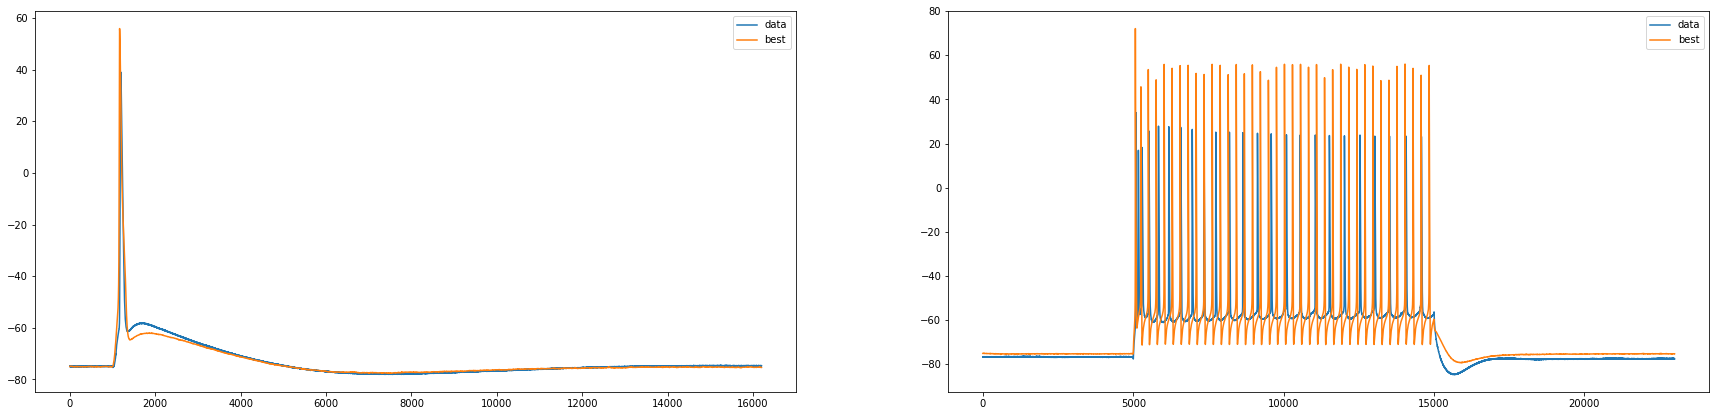

In [10]:
fig, ax  = plt.subplots(ncols=2, figsize=(30,7))
ax[0].plot(vr, label='data')
ax[0].plot(U, label='best')
ax[0].legend();

ax[1].plot(vs, label='data')
ax[1].plot(U_step, label='best');
ax[1].legend();

## Calculate The Features

In [11]:
data_feat_ramp = calc_features_ramp(vr, tr, dtr, t_onr, t_offr)
data_feat_ramp

array([-74.9345 , 113.997  ,   0.73   , -59.96875,  14.21575,  19.73   ,
        -0.75   ,   1.39   , -78.09375])

In [12]:
data_feat_step = calc_features_step(vs, ts, dts, t_ons, t_offs)
data_feat_step

array([-76.63358125, 0.06351057982730121, 48.0, 20.62173913043478,
       6.066798921122928, 24,
       array([254.6 , 258.4 , 264.6 , 275.95, 291.85, 309.  , 328.9 , 347.95,
       367.45, 387.1 , 409.75, 432.15, 456.4 , 479.25, 504.55, 527.35,
       552.55, 575.95, 600.95, 626.85, 651.45, 675.85, 703.5 , 728.9 ])],
      dtype=object)

## Create Comparison DF

#### Ramp Current

In [13]:
df_diff_ramps = np.abs(df_ramps.copy() - data_feat_ramp)
df_diff_ramps['sum'] = df_diff_ramps.sum(axis=1)
df_diff_ramps['sum'] = np.abs(df_diff_ramps['sum'])

df_diff_ramps.index.rename('id', inplace=True)
df_diff_ramps.reset_index(level=0, inplace=True)


#### Step Current

In [14]:
df_diff_steps = df_steps.dropna()
df_diff_steps.drop('spike_times_stim', axis=1, inplace=True)
df_diff_steps = np.abs(df_diff_steps - data_feat_step[:-1])

df_diff_steps.index.rename('id', inplace=True)
df_diff_steps.reset_index(level=0, inplace=True)
df_diff_steps['sum'] = df_diff_steps.drop('spike_count', axis=1).sum(axis=1)


/home/alteska/anaconda3/envs/dap2/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Pick The Best For Both Currents

In [15]:
n = 10
df_best_ramps = df_diff_ramps.sort_values('sum').head(n)
df_best_steps = df_diff_steps.sort_values('spike_count').head(n)

In [16]:
df_best_ramps.head(3)

,id,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
33,1x17,0.168893,15.452289,0.01,4.531615,3.974625,1.77,0.725883,0.80,1.153391,28.586695
5,1x16,0.419646,15.409508,0.00,4.300781,3.984700,3.05,0.735728,0.73,1.559439,30.189803
1,1x35,0.277022,15.254120,0.01,5.268579,4.843041,2.74,0.702560,0.65,0.555398,30.300720


In [17]:
df_best_steps.head(3)

,id,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
13,1x8,5.238063,0.023185,0.0,0.678261,5.271295,0.0,11.210804
18,1x29,8.410363,0.031023,0.0,0.778261,5.528282,0.0,14.747929
15,1x36,3.474407,0.016980,0.0,0.204348,5.038729,0.0,8.734464


## Merge With DFTraces to Get the best Traces and Parameters

In [18]:
names=['id','gbar_nap','gbar_leak','gbar_nat','gbar_kdr','ramp_traces', 'step_traces']

In [19]:
df_best_ramp_tr = pd.merge(df_traces, df_best_ramps)
df_best_ramp_tr.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
0,1x35,17.097219,1.039869,117.684230,3.737484,437.400004,1658.278750,2095.678754,"[-75.00922530838406, -74.99820182662673, -74.9...","[-75.00784688950749, -74.99417353300362, -74.9...",0.277022,15.254120,1.000000e-02,5.268579,4.843041,2.74,0.702560,0.65,0.555398,30.300720
1,1x19,16.370543,1.028504,141.774573,3.430032,572.073793,2563.073617,3135.147410,"[-74.99833127547402, -74.99571285380365, -74.9...","[-74.99079819200841, -74.9674683281197, -74.98...",0.283183,16.437725,1.776357e-15,4.614580,4.163856,2.91,0.733906,0.81,1.320626,31.273876
2,1x16,16.515891,1.121755,120.139337,3.414985,478.165945,2442.751891,2920.917836,"[-75.01251542742355, -75.00151471580077, -74.9...","[-75.0149263037398, -74.97749969716159, -75.00...",0.419646,15.409508,0.000000e+00,4.300781,3.984700,3.05,0.735728,0.73,1.559439,30.189803


In [20]:
df_best_step_tr = pd.merge(df_traces, df_best_steps)[names]
df_best_step_tr

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,ramp_traces,step_traces
0,1x14,17.173732,1.074666,131.422942,3.410514,"[-75.00494597964183, -75.01104047583867, -75.0...","[-75.02404470658469, -74.9609647841243, -74.92..."
1,1x16,16.515891,1.121755,120.139337,3.414985,"[-75.0149263037398, -74.97749969716159, -75.00...","[-75.01251542742355, -75.00151471580077, -74.9..."
2,1x37,17.110439,1.061374,122.224057,3.529461,"[-74.99049013905092, -75.00007970938081, -75.0...","[-74.99891085645093, -74.98222476700472, -74.9..."
3,1x8,17.138812,1.018652,102.838732,3.441273,"[-75.01179262972981, -75.00423252125317, -74.9...","[-75.0029264506616, -74.93250006173989, -74.89..."
4,1x26,16.422258,1.025843,147.327805,3.631141,"[-75.00633348851142, -75.00256614723742, -75.0...","[-74.9948394187083, -75.01226467157416, -75.03..."
5,1x36,16.902639,1.084225,118.188221,3.519692,"[-74.99040384060667, -74.99099961967795, -74.9...","[-74.99034777282598, -74.98950198520265, -74.9..."
6,1x18,16.586808,1.046249,125.779532,3.455369,"[-75.00524597490528, -74.99321458857206, -74.9...","[-75.03238365126367, -74.9525447027717, -74.94..."
7,1x29,17.687560,1.071797,95.583603,3.464703,"[-74.98611469721658, -74.99648724636411, -74.9...","[-75.02642024381075, -74.9550524544294, -74.91..."
8,1x33,18.050893,1.071510,113.726997,3.787249,"[-75.00574671096801, -75.00028054355387, -74.9...","[-74.98943561461752, -74.9885469690878, -74.92..."
9,1x17,16.126095,1.050323,115.380782,3.335470,"[-74.98078829409268, -74.99817593822114, -74.9...","[-74.99339576657718, -74.96000502892709, -74.9..."


## Plot Distributions of Parameters etc.

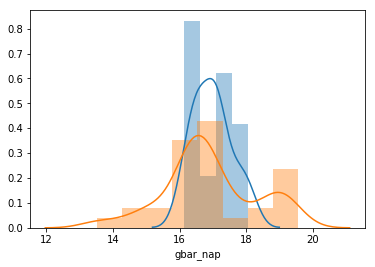

In [21]:
sns.distplot(df_best_step_tr.gbar_nap);
sns.distplot(df_traces.gbar_nap);

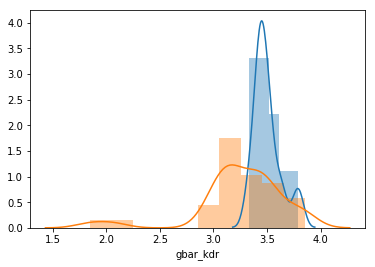

In [22]:
sns.distplot(df_best_step_tr.gbar_kdr);
sns.distplot(df_traces.gbar_kdr);

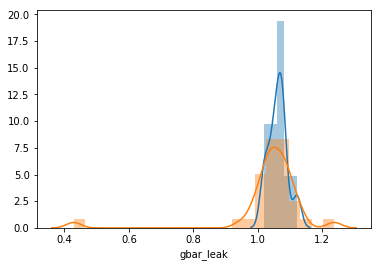

In [23]:
sns.distplot(df_best_step_tr.gbar_leak);
sns.distplot(df_traces.gbar_leak);

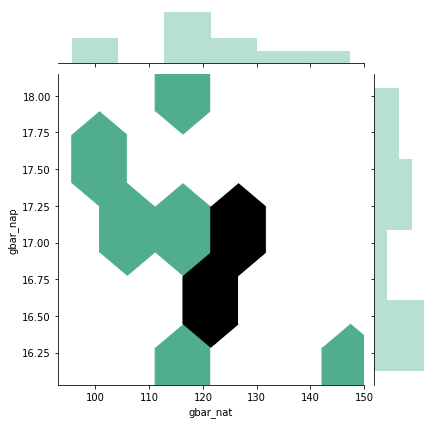

In [24]:
sns.jointplot(df_best_step_tr.gbar_nat, df_best_step_tr.gbar_nap, kind="hex", color="#4CB391")

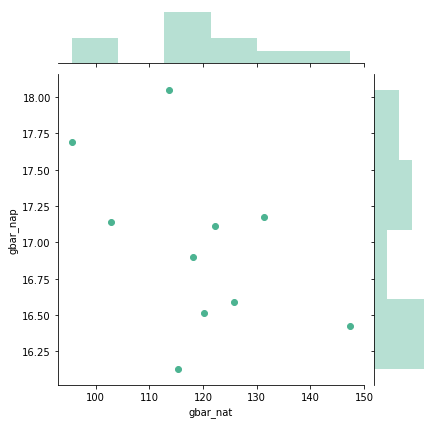

In [25]:
sns.jointplot(df_best_step_tr.gbar_nat, df_best_step_tr.gbar_nap, color="#4CB391")

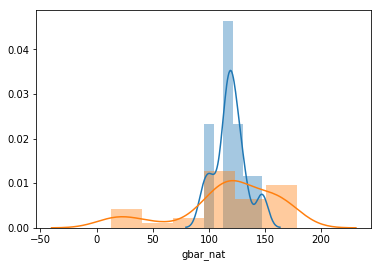

In [26]:
sns.distplot(df_best_step_tr.gbar_nat);
sns.distplot(df_traces.gbar_nat);

In [27]:
# param_labels = ['id','gbar_nap', 'gbar_leak', 'gbar_nat', 'gbar_kdr']
param_labels = ['gbar_nap', 'gbar_leak', 'gbar_nat', 'gbar_kdr']

df = df_traces[param_labels]
df2 = df_best_step_tr[param_labels]

df['label'] = 0
df2['label'] = 1

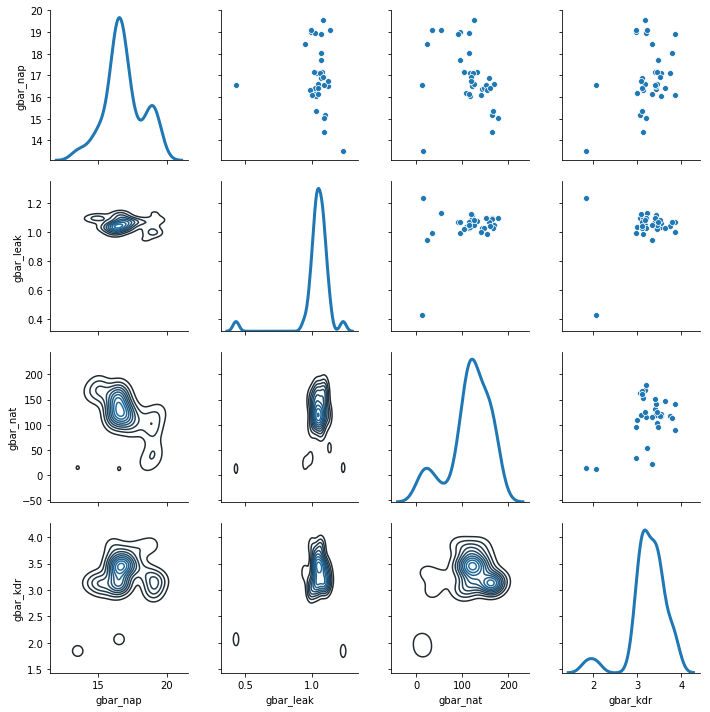

In [28]:
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)

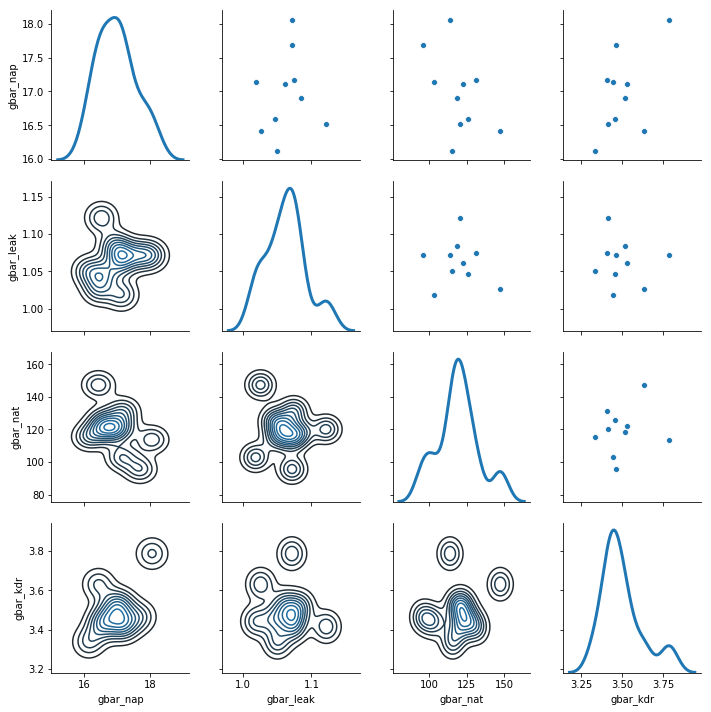

In [31]:
g2 = sns.PairGrid(df2, diag_sharey=False)
g2.map_lower(sns.kdeplot)
g2.map_upper(sns.scatterplot)
g2.map_diag(sns.kdeplot, lw=3)


In [33]:
df_double = pd.concat([df, df2])
df_double.head(3)

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,label
0,17.173732,1.074666,131.422942,3.410514,0
1,17.097219,1.039869,117.684230,3.737484,0
2,19.007380,0.991425,95.365731,2.976070,0


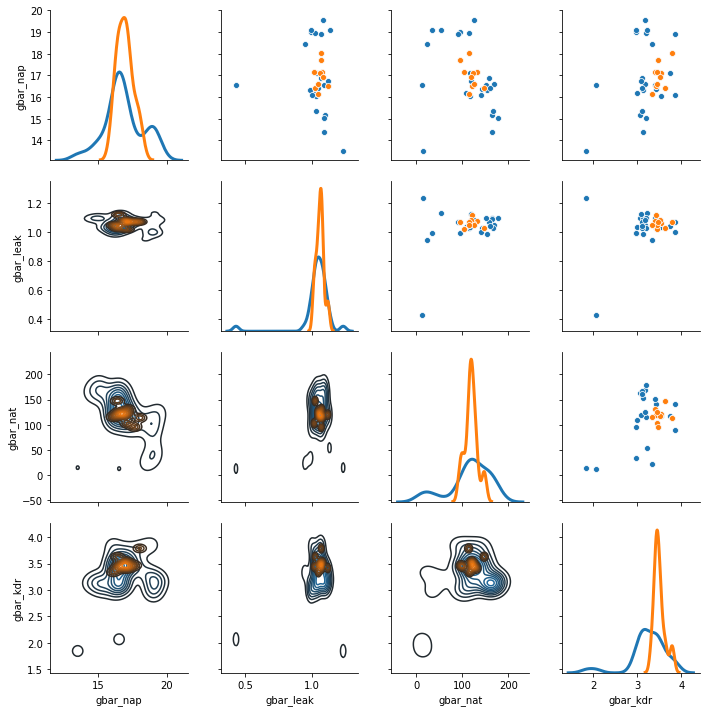

In [35]:
g3 = sns.PairGrid(df_double, vars=param_labels, hue='label', diag_sharey=False)
g3.map_lower(sns.kdeplot)
g3.map_upper(sns.scatterplot)
g3.map_diag(sns.kdeplot, lw=3)
